In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets.MackeyGlassDataset import MackeyGlassDataset
import esn
import utils
from torch.autograd import Variable
from torch.distributions import Normal
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
import numpy as np
import cv2
import gym
from gym import wrappers
from dm_control import suite
from matplotlib import animation
from matplotlib import pyplot as plt
%matplotlib nbagg

from itertools import count
from collections import namedtuple

In [23]:
class ActorCritic(nn.Module):
    def __init__(self, n_action, input_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        self.affine1 = nn.Linear(input_dim, hidden_dim) # for actor
        self.affine2 = nn.Linear(input_dim, hidden_dim) # for critic
        self.action_m_head = nn.Linear(hidden_dim, n_action)
        self.action_std_head = nn.Linear(hidden_dim, n_action)
        self.value_head = nn.Linear(hidden_dim, 1)
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x1 = F.relu(self.affine1(x))
        x2 = F.relu(self.affine2(x))
        action_mean = self.action_m_head(x1)
        action_std = self.action_std_head(x1)
        state_values = self.value_head(x2)
        return action_mean, action_std, state_values

In [24]:
env = suite.load(domain_name="hopper", task_name="hop")
env.reset()
action_spec = env.action_spec()
obs_spec = env.observation_spec()

torch.manual_seed(543)
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [25]:
obs_spec

OrderedDict([('position',
              ArraySpec(shape=(6,), dtype=dtype('float64'), name='position')),
             ('velocity',
              ArraySpec(shape=(7,), dtype=dtype('float64'), name='velocity')),
             ('touch',
              ArraySpec(shape=(2,), dtype=dtype('float64'), name='touch'))])

In [26]:
# Dataset params
sample_length = 1000
n_samples = 40
batch_size = 1

n_action = action_spec.shape[0]
n_obs = 15

# ESN properties
input_dim = n_obs + n_action
n_hidden = 200
w_sparsity=0.1

n_iterations = 50

In [27]:
# Model Definition
resevior = esn.ESN(
    input_dim=input_dim,
    hidden_dim=n_hidden,
    output_dim=1,
    w_sparsity=w_sparsity,
    feedbacks=True,
    skip_output=True
)

model = ActorCritic(n_action, n_hidden)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
eps = np.finfo(np.float32).eps.item()

## Standard Actor-Critic

In [54]:
def select_action(state):
    p_mean, p_std, state_value = model(state)
    m = Normal(p_mean, p_std)
    action = m.sample()
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.numpy()[-1]


def finish_episode(gamma = 0.99):
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)
    for (log_prob, value), r in zip(saved_actions, rewards):
        value = value.view(1)
        reward = r - value.item()
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    print(policy_losses[0].size())
    print(len(value_losses))
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

In [1]:
running_reward = 10
for i_episode in range(1000):
    time_step = env.reset()
    action_arr = [0.,0.,0.,0.]
    for t in range(10000):  # Don't infinite loop while learning
        obs = []
        for key in time_step.observation.keys():
            obs.extend(time_step.observation[key])
        obs.extend(action_arr)
        obs = torch.tensor(np.array(obs).astype("float32").reshape(1, 1, -1))
        obs = Variable(obs)
        state = resevior(obs)
        state = state.detach().numpy().reshape(1, -1)
        state = Variable(torch.tensor(state))
        action = select_action(state)
        time_step = env.step(action)
        state, reward, done, _ = env.step(action)
        model.rewards.append(reward)
        if done or t%100 == 0:
            running_reward = running_reward * 0.99 + t * 0.01
            finish_episode()
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(i_episode, t, running_reward))

NameError: name 'env' is not defined

<IPython.core.display.Javascript object>


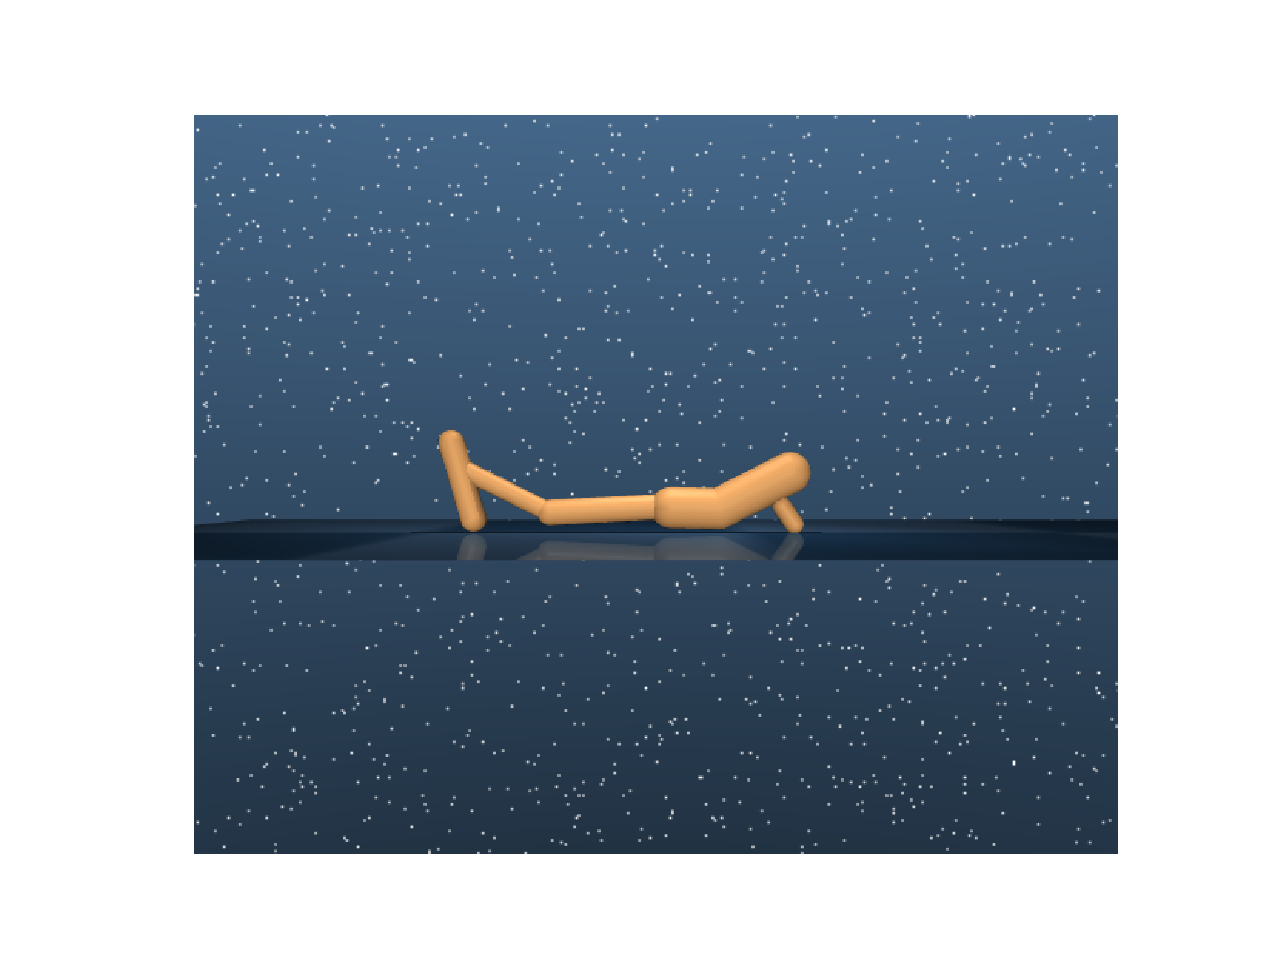

In [15]:
time_step = env.reset()
action_spec = env.action_spec()
frames = []
for t in range(100):
    frame = env.physics.render(480, 600, camera_id=0)
    frames.append(frame)
    action = np.random.uniform(
        action_spec.minimum,
        action_spec.maximum,
        size=action_spec.shape
    )
    time_step = env.step(action)
#     print("action:", action)
#     print("reward:", reward)
#     if done:
#         break
# env.render()

fig = plt.gcf()
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(fig, animate, frames = len(frames), interval=50)
anim

## Save Movie

In [7]:
def grabFrame(env):
    # Get RGB rendering of env
    rgbArr = env.physics.render(480, 600, camera_id=0)
    # Convert to BGR for use with OpenCV
    return cv2.cvtColor(rgbArr, cv2.COLOR_BGR2RGB)

# Setup video writer - mp4 at 30 fps
video_name = 'video.mp4'
frame = grabFrame(env)
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (width, height))

# First pass - Step through an episode and capture each frame
action_spec = env.action_spec()
time_step = env.reset()
while not time_step.last():
    action = np.random.uniform(action_spec.minimum,
                               action_spec.maximum,
                               size=action_spec.shape)
    time_step = env.step(action)
    frame = grabFrame(env)
    # Render env output to video
    video.write(grabFrame(env))

# End render to video file
video.release()

# Second pass - Playback
cap = cv2.VideoCapture(video_name)
while(cap.isOpened()):
    ret, frame = cap.read()
    cv2.imshow('Playback', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()

# Exit
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [28]:
action

array([ 0.79583252,  0.38275723,  0.30363941, -0.17617118])

In [30]:
frame.shape

(480, 600, 3)

In [16]:
time_step

TimeStep(step_type=<StepType.MID: 1>, reward=0.0, discount=1.0, observation=OrderedDict([('position', array([-0.84400851,  1.41385508, -0.06733394,  0.03197032,  0.86060686,
       -0.24751816])), ('velocity', array([-0.02102586, -0.02962681, -0.19051147,  3.17151321, -4.41584522,
       -3.60618596,  1.64793531])), ('touch', array([0., 0.]))]))

In [38]:
for key in time_step.observation.keys():
    print(key, time_step.observation[key])

position [-0.84400851  1.41385508 -0.06733394  0.03197032  0.86060686 -0.24751816]
velocity [-0.02102586 -0.02962681 -0.19051147  3.17151321 -4.41584522 -3.60618596
  1.64793531]
touch [0. 0.]
